<a href="https://colab.research.google.com/github/KimGriezmann/DeepLearning_BeTheLegend/blob/master/MLP_model/MLP_8/4_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2018-21시즌 데이터를 사용한 MLP model**
### Number of data = *29461*
선발 출전한 선수\
3월, 4월 데이터 제외\
Validation data set 추가\
loss & acc graph
### Number of feature = *12*

1. avg (타율)
2. slg (장타율)
3. ops (출루율 + 장타율)
4. home/away_avg_y (홈/원정 별 타율)
5. vs_ab (상대 팀 누적 타수)
6. vs_hit (상대 팀 누적 안타)
7. vs_avg (상대 팀 타율)
8. recent_5days_avg (최근 5일 타율)
9. recent_5games_avg (최근 5경기 타율)
10. recent_10games_avg (최근 10경기 타율)
11. success_10days (최근 10일 성공률)
12. success_10games (최근 10경기 성공률)

acc = 0.682



In [1]:
import numpy as np
import pandas as pd
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [249]:
final_2018_2021 = pd.read_csv('/content/drive/MyDrive/bethelegend/final_2018_2021.csv', encoding='euc-kr')

In [250]:
final_2018_2021

,name,day,vs,result_x,bat_order,position,start_member,ab,score,hit,2_hit,3_hit,homerun,tb,rbi,sb,cs,bb,hpp,ibb,so,gdp,sh,sf,avg,obp,slg,ops,pitch,avLI,RE24,WPA,double,vs_team_x,home/away_x,home_ab_x,home_hit_x,away_ab_x,away_hit_x,home/away_avg_x,vs_team_y,home/away_y,home_ab_y,home_hit_y,away_ab_y,away_hit_y,home/away_avg_y,vs_team,result_y,home/away,vs_ab,vs_hit,vs_avg,recent_5days_avg,recent_5games_avg,recent_10games_avg,success_10days,success_10games
0,강백호,404,한화,W 3:2,4,1B,1,3,0,2,0,0,0,2,0,2,0,1,0,0,0,0,0,0,0.667,NaN,0.667,1.417,16,1.14,0.89,0.122,0.0,한화,home,0,0,0,0,NaN,한화,home,0,0,0,0,0.000,한화,1,home,0,0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
1,강백호,406,LG,L 2:3,4,1B,1,4,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.286,NaN,0.286,0.661,14,2.07,-1.00,-0.183,0.0,LG,home,3,2,0,0,0.667,LG,home,3,2,0,0,0.667,LG,0,home,0,0,0.000,0.666667,0.666667,0.666667,1.000000,1.000000
2,강백호,407,LG,W 7:3,4,1B,1,4,0,3,0,0,0,3,1,0,0,1,0,0,0,0,0,0,0.455,NaN,0.455,0.993,17,1.43,1.75,0.330,0.0,LG,home,7,2,0,0,0.286,LG,home,7,2,0,0,0.286,LG,1,home,4,0,0.000,0.285714,0.285714,0.285714,0.500000,0.500000
3,강백호,408,LG,L 3:7,4,1B,1,4,0,2,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0.467,NaN,0.467,0.996,17,0.89,-0.76,-0.102,0.0,LG,home,11,5,0,0,0.455,LG,home,11,5,0,0,0.455,LG,1,home,8,3,0.375,0.454545,0.454545,0.454545,0.666667,0.666667
4,강백호,409,@삼성,L 5:7,4,1B,1,5,0,3,0,1,0,5,3,0,0,0,0,0,1,1,0,0,0.500,NaN,0.600,1.145,21,0.94,1.88,-0.122,0.0,삼성,away,15,7,0,0,NaN,삼성,away,15,7,0,0,0.000,삼성,1,away,0,0,0.000,0.466667,0.466667,0.466667,0.750000,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39113,강경학,1006,@롯데,L 5:8,9,PH,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.277,NaN,0.393,0.775,6,0.39,-0.25,-0.012,0.0,롯데,away,133,35,108,32,0.296,롯데,away,133,35,108,32,0.296,롯데,0,away,15,3,0.200,0.250000,0.111111,0.200000,0.500000,0.400000
39114,강경학,1009,@KT,W 10:6,8,PH,0,3,1,1,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0.278,NaN,0.392,0.774,15,0.09,-0.03,-0.004,0.0,KT,away,133,35,109,32,0.294,KT,away,133,35,109,32,0.294,KT,1,away,36,12,0.333,0.000000,0.125000,0.222222,0.333333,0.400000
39115,강경학,1019,넥센,L 2:3,9,PR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,NaN,0.000,0.000,0,0.00,0.00,0.000,0.0,넥센,home,133,35,112,33,0.263,넥센,home,133,35,112,33,0.263,넥센,0,home,27,8,0.296,0.000000,0.222222,0.235294,1.000000,0.400000
39116,강경학,1020,넥센,L 5:7,7,PH,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,NaN,0.000,0.000,6,1.94,-0.47,-0.050,0.0,넥센,home,133,35,112,33,0.263,넥센,home,133,35,112,33,0.263,넥센,0,home,27,8,0.296,0.000000,0.250000,0.235294,0.000000,0.400000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


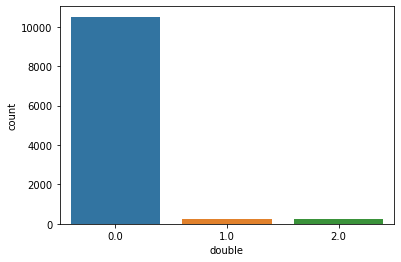

In [ ]:
sns.countplot(ex_2020_data_3['double'])
plt.show()

In [251]:
#선발 출장에 한정
final_2018_2021 = final_2018_2021[final_2018_2021['start_member'] == 1]

In [252]:
#3월, 4월 데이터 제외
final_2018_2021 = final_2018_2021.loc[final_2018_2021['day']>= 500]

In [253]:
#0타수 데이터 제외
final_2018_2021 = final_2018_2021[final_2018_2021['ab']>0]

In [254]:
final_2018_2021

,name,day,vs,result_x,bat_order,position,start_member,ab,score,hit,2_hit,3_hit,homerun,tb,rbi,sb,cs,bb,hpp,ibb,so,gdp,sh,sf,avg,obp,slg,ops,pitch,avLI,RE24,WPA,double,vs_team_x,home/away_x,home_ab_x,home_hit_x,away_ab_x,away_hit_x,home/away_avg_x,vs_team_y,home/away_y,home_ab_y,home_hit_y,away_ab_y,away_hit_y,home/away_avg_y,vs_team,result_y,home/away,vs_ab,vs_hit,vs_avg,recent_5days_avg,recent_5games_avg,recent_10games_avg,success_10days,success_10games
23,강백호,501,KIA,W 3:0,3,1B,1,3,0,2,0,0,0,2,2,0,0,1,0,0,1,0,0,0,0.415,NaN,0.543,1.015,18,1.07,2.13,0.230,0.0,KIA,home,42,19,49,18,0.452,KIA,home,42,19,49,18,0.452,KIA,1,home,2,2,1.000,0.000000,0.400000,0.428571,0.000000,1.0
24,강백호,502,KIA,W 9:2,3,1B,1,4,1,2,1,0,0,3,2,0,0,0,0,0,0,0,0,0,0.418,NaN,0.551,1.025,15,0.79,1.16,-0.015,0.0,KIA,home,45,21,49,18,0.467,KIA,home,45,21,49,18,0.467,KIA,1,home,5,4,0.800,0.666667,0.473684,0.463415,1.000000,1.0
25,강백호,505,@키움,L 0:14,3,1B,1,2,0,1,1,0,0,2,0,0,0,0,0,0,1,0,0,0,0.420,NaN,0.560,1.034,8,0.23,0.05,0.020,0.0,키움,away,49,23,49,18,0.367,키움,away,49,23,49,18,0.367,키움,1,away,12,4,0.333,0.571429,0.500000,0.450000,1.000000,1.0
26,강백호,506,@키움,L 4:6,3,1B,1,4,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.404,NaN,0.538,1.001,21,1.19,-0.78,-0.065,0.0,키움,away,49,23,51,19,0.373,키움,away,49,23,51,19,0.373,키움,0,away,14,5,0.357,0.555556,0.500000,0.473684,1.000000,1.0
27,강백호,508,NC,L 4:5,3,1B,1,3,0,1,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.402,NaN,0.533,1.001,22,1.54,0.48,0.013,0.0,NC,home,49,23,55,19,0.469,NC,home,49,23,55,19,0.469,NC,1,home,13,5,0.385,0.166667,0.466667,0.405405,0.750000,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39103,강경학,916,LG,W 5:1,9,2B,1,3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.281,NaN,0.393,0.782,15,0.32,-0.50,-0.016,0.0,LG,home,118,32,103,31,0.271,LG,home,118,32,103,31,0.271,LG,0,home,21,9,0.429,0.100000,0.071429,0.166667,0.375000,0.4
39104,강경학,918,@NC,L 3:10,9,2B,1,4,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.281,NaN,0.390,0.777,13,0.43,-0.55,-0.030,0.0,NC,away,121,32,103,31,0.301,NC,away,121,32,103,31,0.301,NC,1,away,22,4,0.182,0.125000,0.076923,0.120000,0.142857,0.3
39107,강경학,923,KIA,W 8:6,8,2B,1,3,2,1,0,0,1,4,2,0,0,1,0,0,1,0,0,0,0.284,NaN,0.405,0.798,24,1.41,1.68,0.282,0.0,KIA,home,122,33,107,32,0.270,KIA,home,122,33,107,32,0.270,KIA,1,home,23,5,0.217,0.400000,0.250000,0.130435,0.500000,0.3
39108,강경학,925,삼성,D :,9,2B,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.282,NaN,0.402,0.792,6,0.87,-0.64,-0.041,0.0,삼성,home,125,34,107,32,0.272,삼성,home,125,34,107,32,0.272,삼성,0,home,29,7,0.241,0.500000,0.272727,0.160000,0.600000,0.4


### **Multi layer Perceptron in Be the legend**

In [255]:
mlp_data = final_2018_2021.loc[:, ['name', 'day', 'start_member', 'vs_team', 'avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_ab', 'vs_hit', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games', 'result_y']]

In [256]:
mlp_data

,name,day,start_member,vs_team,avg,slg,ops,avLI,RE24,WPA,home/away_avg_y,vs_ab,vs_hit,vs_avg,recent_5days_avg,recent_5games_avg,recent_10games_avg,success_10days,success_10games,result_y
23,강백호,501,1,KIA,0.415,0.543,1.015,1.07,2.13,0.230,0.452,2,2,1.000,0.000000,0.400000,0.428571,0.000000,1.0,1
24,강백호,502,1,KIA,0.418,0.551,1.025,0.79,1.16,-0.015,0.467,5,4,0.800,0.666667,0.473684,0.463415,1.000000,1.0,1
25,강백호,505,1,키움,0.420,0.560,1.034,0.23,0.05,0.020,0.367,12,4,0.333,0.571429,0.500000,0.450000,1.000000,1.0,1
26,강백호,506,1,키움,0.404,0.538,1.001,1.19,-0.78,-0.065,0.373,14,5,0.357,0.555556,0.500000,0.473684,1.000000,1.0,0
27,강백호,508,1,NC,0.402,0.533,1.001,1.54,0.48,0.013,0.469,13,5,0.385,0.166667,0.466667,0.405405,0.750000,0.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39103,강경학,916,1,LG,0.281,0.393,0.782,0.32,-0.50,-0.016,0.271,21,9,0.429,0.100000,0.071429,0.166667,0.375000,0.4,0
39104,강경학,918,1,NC,0.281,0.390,0.777,0.43,-0.55,-0.030,0.301,22,4,0.182,0.125000,0.076923,0.120000,0.142857,0.3,1
39107,강경학,923,1,KIA,0.284,0.405,0.798,1.41,1.68,0.282,0.270,23,5,0.217,0.400000,0.250000,0.130435,0.500000,0.3,1
39108,강경학,925,1,삼성,0.282,0.402,0.792,0.87,-0.64,-0.041,0.272,29,7,0.241,0.500000,0.272727,0.160000,0.600000,0.4,0


In [257]:
len(mlp_data)

29395

In [75]:
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.preprocessing import minmax_scale
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

### **Training data set / Test data set 분할**

In [258]:
mlp_train, mlp_test = train_test_split(mlp_data, test_size=0.3, random_state=50)

In [260]:
#현재 가지고 있는 모든 피쳐 사용

X_train = mlp_train.loc[:, ['avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
y_train = mlp_train.loc[:, ['result_y']]

X_test = mlp_test.loc[:, ['avg', 'slg', 'ops', 'avLI', 'RE24', 'WPA', 'home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
y_test = mlp_test.loc[:, ['result_y']]

In [125]:
#홈/원정 타율, 상대 타율, 최근 5일 타율, 최근 5게임 타율, 최근 10게임 타율, 최근 10일 성공률, 최근 10경기 성공률 사용

# X_train = mlp_train.loc[:, ['home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
# y_train = mlp_train.loc[:, ['result_y']]

# X_test = mlp_test.loc[:, ['home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg', 'success_10days', 'success_10games']]
# y_test = mlp_test.loc[:, ['result_y']]

In [134]:
#홈/원정 타율, 상대 타율, 최근 5일 타율, 최근 5게임 타율, 최근 10게임 타율

# X_train = mlp_train.loc[:, ['home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg']]
# y_train = mlp_train.loc[:, ['result_y']]

# X_test = mlp_test.loc[:, ['home/away_avg_y', 'vs_avg', 'recent_5days_avg', 'recent_5games_avg', 'recent_10games_avg']]
# y_test = mlp_test.loc[:, ['result_y']]

In [261]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [262]:
number_of_train_samples = X_train.shape[0]
width = X_train.shape[1]
X_train = X_train.reshape(number_of_train_samples, width)

In [263]:
number_of_test_samples = X_test.shape[0]
X_test = X_test.reshape(number_of_test_samples, width)

In [264]:
X_train = minmax_scale(X_train, feature_range=(0,1), axis = 0)
X_test = minmax_scale(X_test, feature_range=(0,1), axis = 0)

In [265]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### **Validation data set / Training data set 분할**

In [268]:
X_val = X_train[:5000]
X_train = X_train[5000:]

y_val = y_train[:5000]
y_train = y_train[5000:]

### **MLP Model**

In [269]:
#Activation = Relu & Sigmoid
model = Sequential()

model.add(Dense(32, input_dim= width, kernel_initializer = 'glorot_uniform', activation = 'relu'))

# model.add(Dense(96, kernel_initializer = 'glorot_uniform', activation = 'relu'))
model.add(Dense(48, activation = 'relu'))
model.add(Dense(2, activation = 'sigmoid'))

In [154]:
#Activation = Sigmoid
model = Sequential()

model.add(Dense(512, input_dim= width, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
# model.add(Dropout(0.3))
model.add(Dense(300, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
model.add(Dense(256, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

model.add(Dense(128, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

model.add(Dense(64, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

model.add(Dense(32, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
model.add(Dense(16, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
model.add(Dense(2, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

### **Model training**

In [270]:
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics=['acc'])

history = model.fit(X_train, y_train, epochs = 200, batch_size = 64, validation_data=(X_val, y_val))
history_dict = history.history
history_dict.keys()

Epoch 1/200
244/244 [==============================] - 2s 3ms/step - loss: 0.6236 - acc: 0.6490 - val_loss: 0.5269 - val_acc: 0.7134
Epoch 2/200
244/244 [==============================] - 0s 2ms/step - loss: 0.5229 - acc: 0.7204 - val_loss: 0.4674 - val_acc: 0.7466
Epoch 3/200
244/244 [==============================] - 1s 2ms/step - loss: 0.4695 - acc: 0.7616 - val_loss: 0.4357 - val_acc: 0.7878
Epoch 4/200
244/244 [==============================] - 0s 2ms/step - loss: 0.4537 - acc: 0.7824 - val_loss: 0.4269 - val_acc: 0.7924
Epoch 5/200
244/244 [==============================] - 0s 2ms/step - loss: 0.4395 - acc: 0.7897 - val_loss: 0.4227 - val_acc: 0.7968
Epoch 6/200
244/244 [==============================] - 0s 2ms/step - loss: 0.4280 - acc: 0.7992 - val_loss: 0.4191 - val_acc: 0.8022
Epoch 7/200
244/244 [==============================] - 0s 2ms/step - loss: 0.4273 - acc: 0.7962 - val_loss: 0.4131 - val_acc: 0.8050
Epoch 8/200
244/244 [==============================] - 0s 2ms/step - 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

### **Graph_loss & acc**

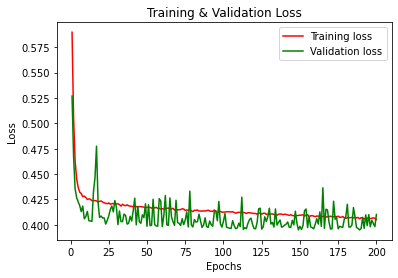

In [271]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'red', label='Training loss') 
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

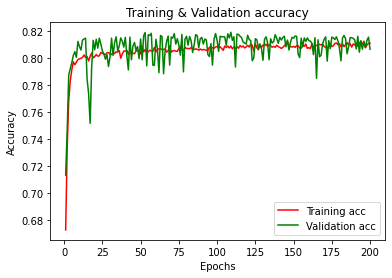

In [272]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'red', label='Training acc') 
plt.plot(epochs, val_acc, 'green', label='Validation acc')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [201]:
history = model.fit(X_train, y_train, epochs= 100, batch_size = 512)

Epoch 1/100
47/47 [==============================] - 1s 3ms/step - loss: 0.6419 - accuracy: 0.6719
Epoch 2/100
47/47 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6759
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6199 - accuracy: 0.6781
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6192 - accuracy: 0.6779
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6168 - accuracy: 0.6819
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6170 - accuracy: 0.6816
Epoch 7/100
47/47 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6800
Epoch 8/100
47/47 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.6849
Epoch 9/100
47/47 [==============================] - 0s 3ms/step - loss: 0.6092 - accuracy: 0.6854
Epoch 10/100
47/47 [==============================] - 0s 3ms/step - loss: 0.6102 - accuracy: 0.6842
Epoch 11/

In [204]:
#Activation Relu & Sigmoid
loss_and_metrics = model.evaluate(X_test, y_test, batch_size = 512)

12/12 [==============================] - 0s 2ms/step - loss: 0.6051 - accuracy: 0.6793


In [156]:
#Activation Sigmoid & Softmax
loss_and_metrics = model.evaluate(X_test, y_test, batch_size = 32)

185/185 [==============================] - 1s 2ms/step - loss: 0.6350 - accuracy: 0.6693


In [170]:
#Activation Relu & Softmax
loss_and_metrics = model.evaluate(X_test, y_test, batch_size = 32)

185/185 [==============================] - 1s 2ms/step - loss: 0.6038 - accuracy: 0.6796


In [157]:
len(mlp_data[mlp_data['result_y'] ==1]) / len(mlp_data) * 100

67.31950714503921

In [273]:
#Latest try: Activation Relu & Sigmoid
loss_and_metrics = model.evaluate(X_test, y_test, batch_size = 64)

138/138 [==============================] - 0s 1ms/step - loss: 0.4036 - acc: 0.8127
